Read in data from the "Retail Sales By Fuel Type" sheet of the ACTSEP23.xlsx spreadsheet from my uploaded files in the VFACTS folder using row 5 as column names.

In [1]:
import pandas as pd
from pathlib import Path
import plotly.express as px
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 34.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
def get_single_vfacts_sales_data(filepath):
    new_sheet_name = 'Retail Sales By Fuel Type'
    old_sheet_name = 'Retail Sales By Buyer Type Fuel'
    month_number = {'JAN':'01','FEB':'02','MAR':'03','APR':'04','MAY':'05','JUN':'06','JUL':'07','AUG':'08','SEP':'09','OCT':'10','NOV':'11','DEC':'12'}
    new = True
    if new_sheet_name in pd.ExcelFile(filepath).sheet_names:
        sheet_name = new_sheet_name
        categories = ['Passenger','SUV','Light Commercial']
    else:
        new = False
        sheet_name = old_sheet_name
        categories = ['Passenger Private','Passenger Non-Private','SUV Private','SUV Non-Private','Light Commercial Private','Light Commercial Non-Private']

    sales_data = pd.read_excel(filepath, sheet_name=sheet_name, header=4)
    if Path(filepath).stem[:2] in ['NT','SA','WA']:
        state = Path(filepath).stem[:2]
        month = month_number[Path(filepath).stem[2:5]]
        year = '20'+Path(filepath).stem[5:7]
    else:
        state = Path(filepath).stem[:3]
        month = month_number[Path(filepath).stem[3:6]]
        year = '20'+Path(filepath).stem[6:8]
    date = year + '-' + month 
    print(state, month, year)
    print(new)
    col_names = ['State','Vehicle Type','Fuel Type',date]
    sales_df = pd.DataFrame(columns=col_names)
    for t in categories:
        srow = sales_data.index[sales_data['Total Market'] == t][0]+1
        erow = sales_data.iloc[srow:,0].isnull().idxmax()-1
        ytd_year = year+'.1'
        mnth_year = int(year)
        this_year = mnth_year
        #print(sales_data.columns)
        df = sales_data.loc[srow:erow,['Total Market',this_year]]
        df['State'] = [state]*df.shape[0]
        df['Vehicle Type'] = [t]*df.shape[0]
        df.rename(columns={this_year:date,'Total Market':'Fuel Type'}, inplace=True)
        df = df.reindex(columns=col_names)
        sales_df = pd.concat([sales_df, df])
    if ~new: # collapse over the Private and Non-Private categories
        sales_df['Vehicle Type'] = sales_df['Vehicle Type'].str.replace(' Private','').str.replace(' Non-Private','')
        sales_df = sales_df.groupby(['State','Vehicle Type','Fuel Type'],as_index=False).sum()
    print('DONE')
    return sales_df

In [21]:
def get_vfacts_sales_data():
    files = sorted(Path("VFACTS").glob("[A-Z]*.xlsx"))
    # files = [f for f in files][8:12]
    sales_df = None
    for f in files:
        print(f)
        df = get_single_vfacts_sales_data(f)
        #dfm1 = sales_df
        if sales_df is not None:
            sales_df = pd.merge(
                sales_df, df, how="outer", on=["State", "Vehicle Type", "Fuel Type"]
            )
            # deal with the non-match on the date columns
            this_date = df.columns[-1]
            thisx = this_date + "_x"
            thisy = this_date + "_y"
            if thisx in sales_df.columns and thisy in sales_df.columns:
                sales_df[this_date] = sales_df[thisx].fillna(0) + sales_df[
                    thisy
                ].fillna(0)
                sales_df.drop([thisx, thisy], axis=1, inplace=True)
        else:
            sales_df = df

    scols = sorted(sales_df.columns)
    sales_df = sales_df.reindex(
        columns=["State", "Vehicle Type", "Fuel Type"] + scols[0:-3]
    )

    # take out 2020-03 and 2020-06 as they combine electric+PHEV
    if "2020-03" in sales_df.columns:
        sales_df.drop("2020-03", axis=1, inplace=True)
    if "2020-06" in sales_df.columns:
        sales_df.drop("2020-06", axis=1, inplace=True)
    # filter out the 'Electric/PHEV' rows
    sales_df = sales_df[sales_df["Fuel Type"] != "Electric/PHEV"]
    # write to file
    sales_df.to_csv("vfacts_sales_df.csv")
    return sales_df#, dfm1, df


vfacts_df = get_vfacts_sales_data()
vfacts_df

VFACTS/ACTDEC20.xlsx
ACT 12 2020
True
DONE
VFACTS/ACTDEC22.xlsx
ACT 12 2022
True
DONE
VFACTS/ACTJUN20.xlsx
ACT 06 2020
False
DONE
VFACTS/ACTJUN21.xlsx
ACT 06 2021
True
DONE
VFACTS/ACTJUN22.xlsx
ACT 06 2022
True
DONE
VFACTS/ACTJUN23.xlsx
ACT 06 2023
True
DONE
VFACTS/ACTMAR20.xlsx
ACT 03 2020
False
DONE
VFACTS/ACTMAR21.xlsx
ACT 03 2021
True
DONE
VFACTS/ACTMAR23.xlsx
ACT 03 2023
True
DONE
VFACTS/ACTSEP20.xlsx
ACT 09 2020
True
DONE
VFACTS/ACTSEP22.xlsx
ACT 09 2022
True
DONE
VFACTS/ACTSEP23.xlsx
ACT 09 2023
True
DONE
VFACTS/NSWDEC20.xlsx
NSW 12 2020
True
DONE
VFACTS/NSWDEC22.xlsx
NSW 12 2022
True
DONE
VFACTS/NSWJUN20.xlsx
NSW 06 2020
False
DONE
VFACTS/NSWJUN21.xlsx
NSW 06 2021
True
DONE
VFACTS/NSWJUN22.xlsx
NSW 06 2022
True
DONE
VFACTS/NSWJUN23.xlsx
NSW 06 2023
True
DONE
VFACTS/NSWMAR20.xlsx
NSW 03 2020
False
DONE
VFACTS/NSWMAR21.xlsx
NSW 03 2021
True
DONE
VFACTS/NSWMAR23.xlsx
NSW 03 2023
True
DONE
VFACTS/NSWSEP20.xlsx
NSW 09 2020
True
DONE
VFACTS/NSWSEP22.xlsx
NSW 09 2022
True
DONE
VFACTS/

,State,Vehicle Type,Fuel Type,2020-09,2020-12,2021-03,2021-06,2022-06,2022-09,2022-12,2023-03,2023-06,2023-09
0,ACT,Light Commercial,Diesel,190.0,227.0,251.0,252.0,226.0,219.0,171.0,162.0,193.0,178.0
1,ACT,Light Commercial,Electric,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
2,ACT,Light Commercial,Petrol,18.0,30.0,21.0,20.0,18.0,45.0,36.0,36.0,30.0,42.0
3,ACT,Passenger,Diesel,8.0,4.0,16.0,16.0,10.0,16.0,14.0,13.0,22.0,24.0
4,ACT,Passenger,Electric,3.0,6.0,13.0,15.0,47.0,93.0,18.0,97.0,85.0,148.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,WA,SUV,Diesel,859.0,1411.0,1101.0,1292.0,1330.0,920.0,1081.0,994.0,1465.0,1108.0
118,WA,SUV,Electric,10.0,7.0,6.0,37.0,45.0,451.0,210.0,302.0,860.0,500.0
119,WA,SUV,Hybrid,312.0,377.0,348.0,292.0,526.0,238.0,451.0,461.0,647.0,589.0
120,WA,SUV,PHEV,8.0,15.0,12.0,20.0,45.0,30.0,31.0,42.0,80.0,140.0


In [20]:
## sum over the quarterly values
#for year in range(2020, 2030):
#    cols = [col for col in vfacts_df.columns if col.startswith(str(year)+'-')]
#    if len(cols) > 0:
#        vfacts_df[str(year)] = vfacts_df[cols].sum(axis=1)
#    if len(cols)>0:
#        vfacts_df.drop(cols, axis=1, inplace=True)

In [22]:
vfacts_df

,State,Vehicle Type,Fuel Type,2020-09,2020-12,2021-03,2021-06,2022-06,2022-09,2022-12,2023-03,2023-06,2023-09
0,ACT,Light Commercial,Diesel,190.0,227.0,251.0,252.0,226.0,219.0,171.0,162.0,193.0,178.0
1,ACT,Light Commercial,Electric,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
2,ACT,Light Commercial,Petrol,18.0,30.0,21.0,20.0,18.0,45.0,36.0,36.0,30.0,42.0
3,ACT,Passenger,Diesel,8.0,4.0,16.0,16.0,10.0,16.0,14.0,13.0,22.0,24.0
4,ACT,Passenger,Electric,3.0,6.0,13.0,15.0,47.0,93.0,18.0,97.0,85.0,148.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,WA,SUV,Diesel,859.0,1411.0,1101.0,1292.0,1330.0,920.0,1081.0,994.0,1465.0,1108.0
118,WA,SUV,Electric,10.0,7.0,6.0,37.0,45.0,451.0,210.0,302.0,860.0,500.0
119,WA,SUV,Hybrid,312.0,377.0,348.0,292.0,526.0,238.0,451.0,461.0,647.0,589.0
120,WA,SUV,PHEV,8.0,15.0,12.0,20.0,45.0,30.0,31.0,42.0,80.0,140.0


In [ ]:
state_type_df = vfacts_df.loc[(vfacts_df['State'] == 'NSW') & (vfacts_df['Vehicle Type'] == 'Passenger')]

In [ ]:
vfacts_df_long = state_type_df.melt(id_vars=['State','Vehicle Type','Fuel Type'], var_name='Date', value_name='Sales Per Month')

In [ ]:
DeepnoteChart(vfacts_df_long, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"area","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"ordinal","field":"Date","scale":{"type":"linear"},"timeUnit":"yearmonth"},"y":{"sort":null,"type":"quantitative","field":"Sales Per Month","scale":{"type":"linear"},"stack":"normalize","format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"sort":null,"type":"nominal","field":"Fuel Type","scale":{"scheme":"tableau20"}}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

In [ ]:
df_t = vfacts_df.groupby(['Fuel Type']).sum().transpose()
df_t.reset_index(inplace=True)
df_t

Fuel Type,index,Diesel,Electric,Hybrid,Hydrogen,PHEV,Petrol
0,2020-09,21539.0,161.0,4389.0,0.0,124.0,39926.0
1,2020-12,32693.0,180.0,6124.0,0.0,236.0,52893.0
2,2021-03,32228.0,411.0,6548.0,0.0,286.0,56847.0
3,2021-06,38285.0,526.0,5842.0,0.0,318.0,60701.0
4,2022-06,35306.0,1137.0,6407.0,1.0,570.0,51388.0
5,2022-09,29377.0,7247.0,4616.0,0.0,525.0,47620.0
6,2022-12,27621.0,5084.0,7082.0,2.0,460.0,43332.0
7,2023-03,30063.0,6612.0,5247.0,0.0,569.0,50229.0
8,2023-06,37497.0,11042.0,9020.0,0.0,735.0,59995.0
9,2023-09,33614.0,8821.0,10138.0,0.0,1264.0,52619.0


In [ ]:
DeepnoteChart(df_t, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"ordinal","field":"index","scale":{"type":"linear"},"stack":"zero","timeUnit":"yearmonth"},"y":{"sort":null,"type":"quantitative","field":"Diesel","scale":{"type":"linear"},"stack":"zero","format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"sort":null,"type":"quantitative","field":"Diesel","scale":{"scheme":"goldgreen"},"aggregate":"sum"}}}]},{"layer":[{"mark":{"clip":true,"type":"area","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"temporal","field":"index","scale":{"type":"linear"},"stack":"zero"},"y":{"sort":null,"type":"quantitative","field":"Hydrogen","scale":{"type":"linear"},"stack":"zero","format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"sort":null,"type":"quantitative","field":"Hydrogen","scale":{"scheme":"oranges"},"aggregate":"sum"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

In [ ]:
DeepnoteChart(vfacts_df, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"area","color":"#4c78a8","tooltip":true},"encoding":{"x":{"sort":null,"scale":{"type":"linear"},"stack":"zero"},"y":{"sort":null,"scale":{"type":"linear"},"stack":"zero"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

In [ ]:
df0 =vfacts_national.loc[('Passenger',slice(None))].transpose()
df0

Fuel Type,Diesel,Electric,Hybrid,Hydrogen,PHEV,Petrol
2020-09,388.0,96.0,1814.0,0.0,32.0,15390.0
2020-12,338.0,66.0,2654.0,0.0,53.0,16866.0
2021-03,860.0,233.0,2658.0,0.0,28.0,17581.0
2021-06,559.0,161.0,2020.0,0.0,46.0,20575.0
2022-06,1300.0,574.0,2165.0,1.0,49.0,14361.0
2022-09,1125.0,1891.0,1626.0,0.0,41.0,12807.0
2022-12,930.0,2141.0,1771.0,2.0,28.0,10069.0
2023-03,870.0,2187.0,1466.0,0.0,32.0,12627.0
2023-06,1289.0,2254.0,2417.0,0.0,47.0,14390.0
2023-09,1304.0,2714.0,3038.0,0.0,52.0,11503.0


In [ ]:
DeepnoteChart(df0, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"trail","tooltip":true},"encoding":{"x":{"sort":null,"scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"Electric","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"size":{"sort":null,"type":"quantitative","field":"Diesel"},"color":{"sort":null,"type":"quantitative","field":"Diesel","scale":{"scheme":"blues"}}}},{"mark":{"size":100,"type":"point","opacity":0,"tooltip":true},"encoding":{"x":{"sort":null,"scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"Electric","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"size":{"sort":null,"type":"quantitative","field":"Diesel"},"color":{"sort":null,"type":"quantitative","field":"Diesel","scale":{"scheme":"blues"}}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

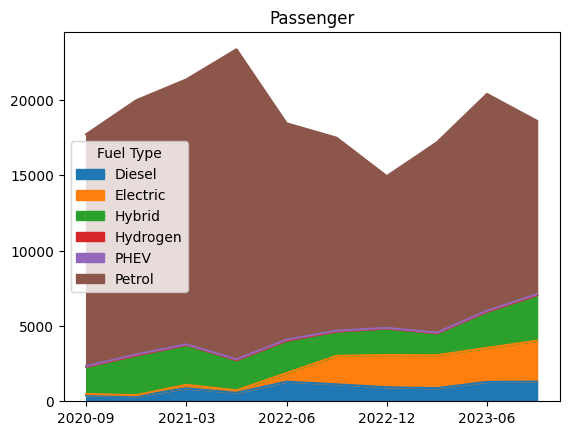

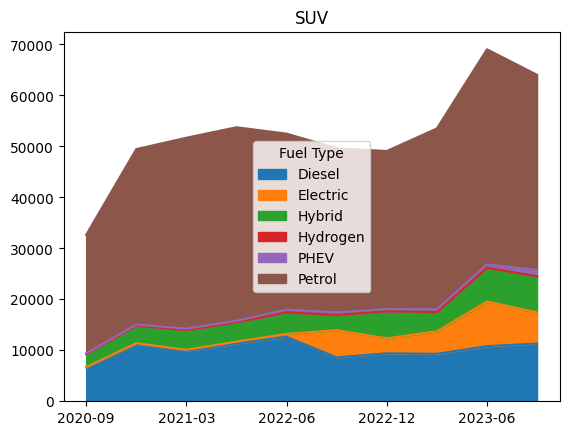

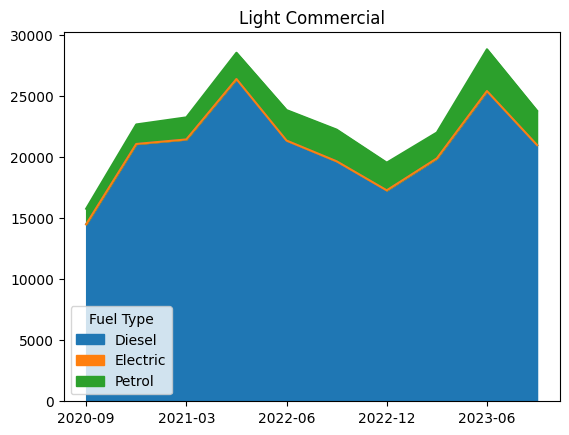

In [ ]:
# national level plotting
vfacts_national = vfacts_df.groupby(['Vehicle Type','Fuel Type']).sum()
for t in ['Passenger','SUV','Light Commercial']:
    vfacts_national.loc[(t,slice(None))].transpose().plot.area(title=t)


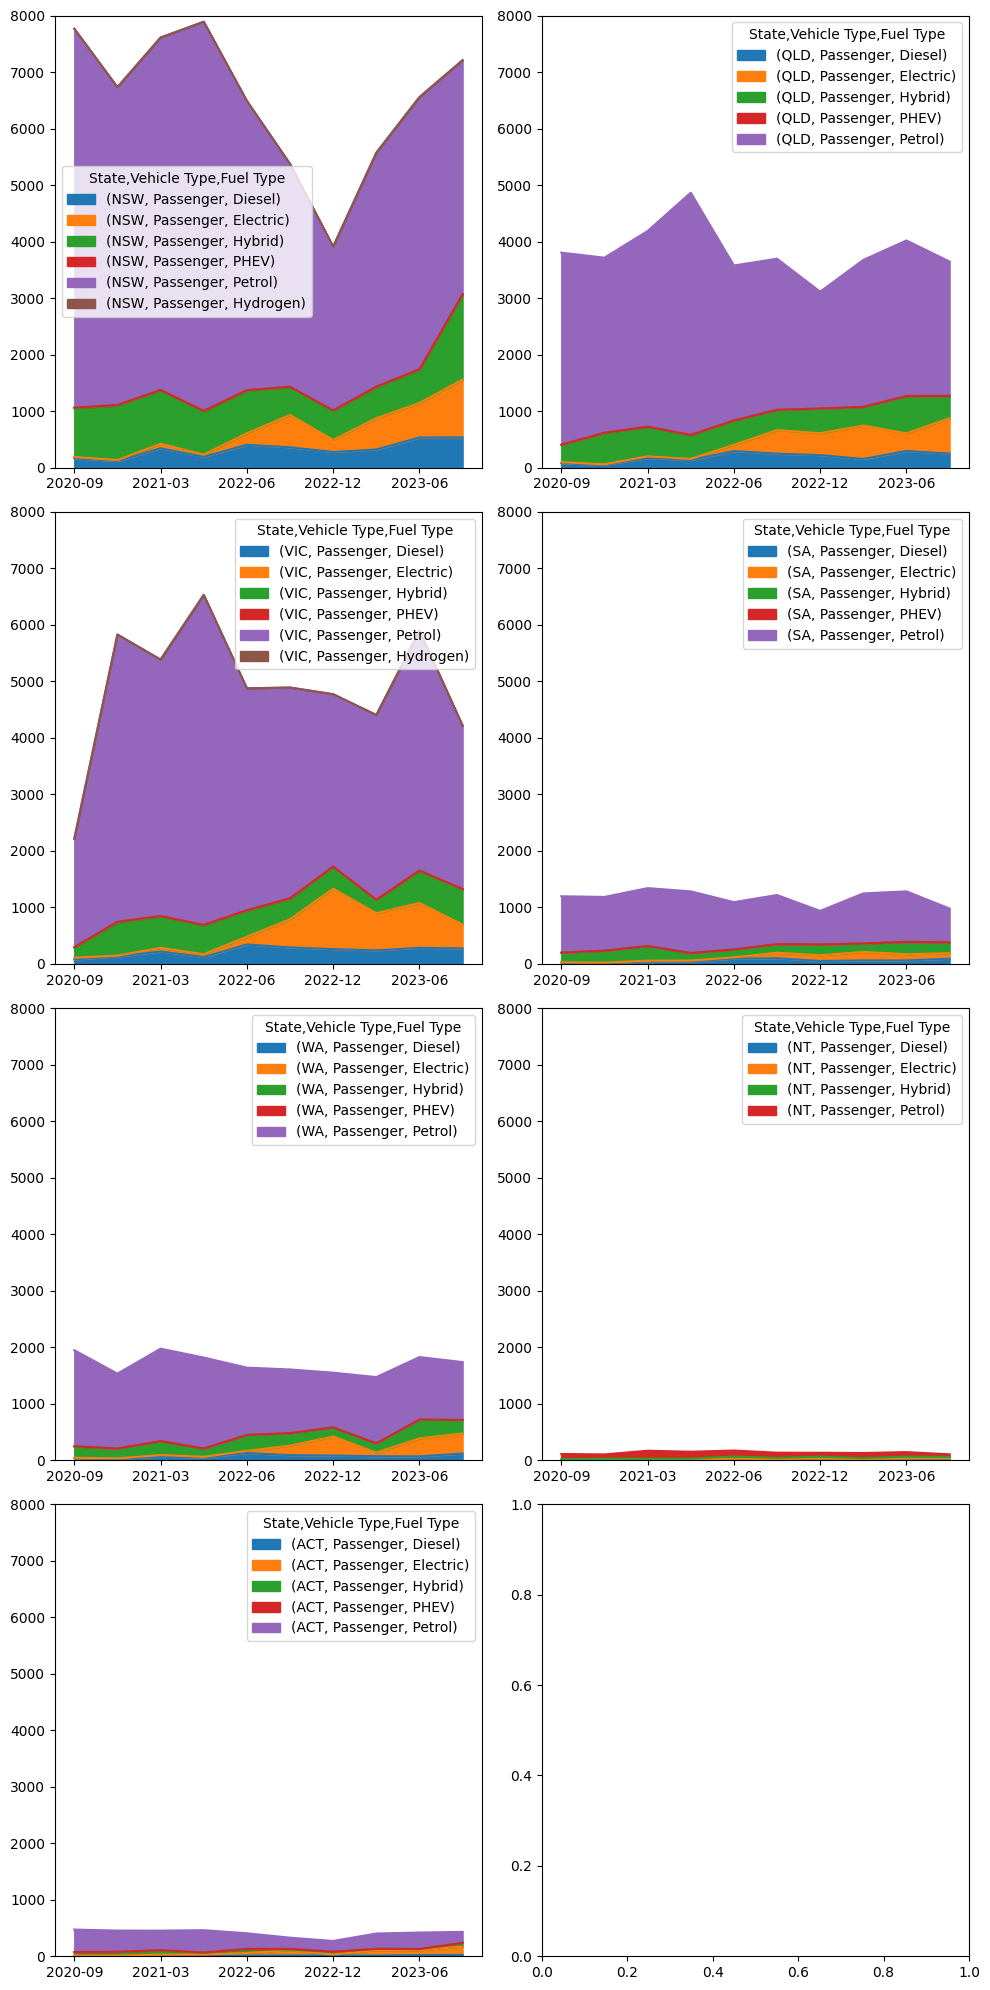

In [ ]:
# state level plotting
import matplotlib.pyplot as plt
vfacts_df_mi = vfacts_df.set_index(['State','Vehicle Type','Fuel Type'])
nrows = 4
ncols = 2
fig, axs = plt.subplots(nrows, ncols)
states = ['NSW', 'QLD', 'VIC', 'SA', 'WA', 'NT', 'ACT']
vehicle_type = 'Passenger'
for s in range(len(states)):
    ax = axs[s//ncols, s%ncols]
    vfacts_df_mi.loc[(states[s], vehicle_type, slice(None))].transpose().plot.area(ax=ax, ylim=(0, 8000))
fig.set_figwidth(10)
fig.set_figheight(20)
plt.tight_layout()
plt.show()

In [ ]:
vfacts_df_trans = vfacts_df.transpose()

In [ ]:
DeepnoteChart(vfacts_df_trans, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#4c78a8","tooltip":true},"encoding":{"x":{"sort":null,"scale":{"type":"linear","zero":false}},"y":{"sort":"ascending","type":"temporal","field":16,"scale":{"type":"linear","zero":false}}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

ValueError: Dataframe contains invalid column name: 0. Column names must be strings

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=75de7644-8bd4-4ecc-bdb2-2c9ef0ed94e0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>